## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from lib.sb_utils import save_file

## Load Data

In [2]:
college_data = pd.read_csv('../data/college_data_EDA.csv')
college_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  349 non-null    object 
 1   Private               349 non-null    int64  
 2   Top10perc             349 non-null    int64  
 3   Top25perc             349 non-null    int64  
 4   Room.Board            349 non-null    int64  
 5   PhD                   349 non-null    int64  
 6   S.F.Ratio             349 non-null    float64
 7   perc.alumni           349 non-null    int64  
 8   Expend                349 non-null    int64  
 9   Grad.Rate             349 non-null    int64  
 10  out_of_state_tuition  349 non-null    float64
 11  state_mean            349 non-null    float64
dtypes: float64(3), int64(8), object(1)
memory usage: 32.8+ KB


In [3]:
purdue = college_data[college_data.name.str.match('^Purdue')]
college_data = college_data[~college_data.name.str.match('^Purdue')]
purdue.head()

,name,Private,Top10perc,Top25perc,Room.Board,PhD,S.F.Ratio,perc.alumni,Expend,Grad.Rate,out_of_state_tuition,state_mean
198,Purdue University at West Lafayette,0,29,60,3990,86,18.2,15,8604,67,28794.0,34490.31


## Train/Test Split

In [ ]:
# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='retained'), 
                                                    df.retained,
                                                    test_size=0.3,
                                                    random_state=67)

In [5]:
# Drop but save name column
names_train = X_train['name']
names_test = X_test['name']
X_train.drop(columns='name', inplace=True)
X_test.drop(columns='name', inplace=True)
X_train.shape, X_test.shape

((243, 10), (105, 10))

In [6]:
# Ensure modelable dtypes
X_train.dtypes

Private          int64
Top10perc        int64
Top25perc        int64
Room.Board       int64
PhD              int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
state_mean     float64
dtype: object

In [ ]:
# Make sure no missing values
college_data.isna().sum()

name                    0
Private                 0
Top10perc               0
Top25perc               0
Room.Board              0
PhD                     0
S.F.Ratio               0
perc.alumni             0
Expend                  0
Grad.Rate               0
out_of_state_tuition    0
state_mean              0
dtype: int64

## GridSearch - Logistic Regression

In [ ]:
# Linear regression pipeline
lr_pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LogisticRegression()
)

In [ ]:
# Different hyperparameters to test
k = np.arange(1, len(X_train.columns)+1)
param_grid = {'selectkbest__k': k}

In [ ]:
# Grid search for hyperparameters
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=param_grid, cv=5, n_jobs=-1)

In [ ]:
# Fit to training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x1797d4b80>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [ ]:
# Print the best parameters
lr_grid_cv.best_params_

{'selectkbest__k': np.int64(10)}

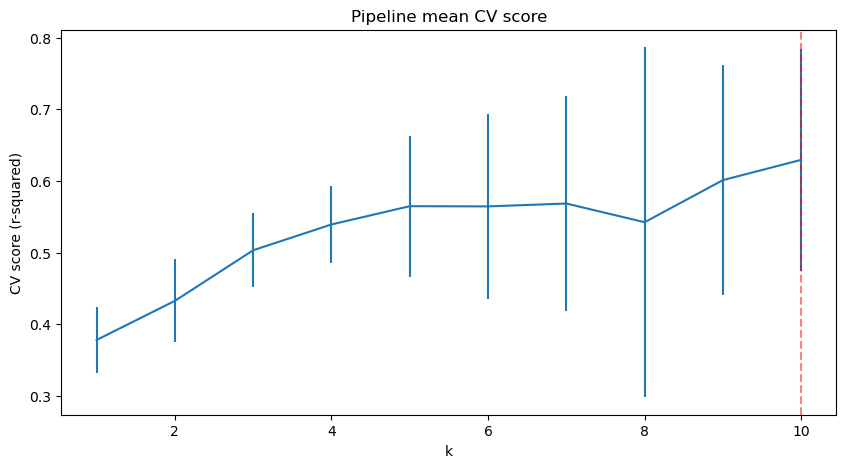

In [ ]:
# Display performance at different number of features (k)
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score');

In [ ]:
# Top features according to model
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=True)

Top10perc      -351.897690
S.F.Ratio       187.887880
perc.alumni    1305.235760
Grad.Rate      1384.891237
Expend         1828.928215
Room.Board     1967.351953
state_mean     2038.502333
Top25perc      2046.487839
PhD            2787.323359
Private        3529.365450
dtype: float64

## GridSearch - Random Forest

In [ ]:
# Random forest pipeline
rf_pipe = make_pipeline(
    SelectKBest(f_regression),
    RandomForestClassifier(random_state=47)
)

In [ ]:
# Different hyperparamters to test
k = np.arange(1, len(X_train.columns)+1)
param_grid = {
    'selectkbest__k': k,
    'randomforestclassifier__n_estimators': randint(50, 300),
    'randomforestclassifier__max_depth': randint(3, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20),
    'randomforestclassifier__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__bootstrap': [True, False]
}

In [ ]:
# Grid search for hyperparameters
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=param_grid, cv=5, n_jobs=-1)

In [ ]:
# Fit to trianing data
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x1797d4b80>)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 20, 30],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 10],
                         'randomforestregressor__n_estimators': [10, 25, 50,
                                                                 100, 200,
                                                                 500],
                         'selectkbest__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [ ]:
# Print the best parameters
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 25,
 'selectkbest__k': np.int64(10)}

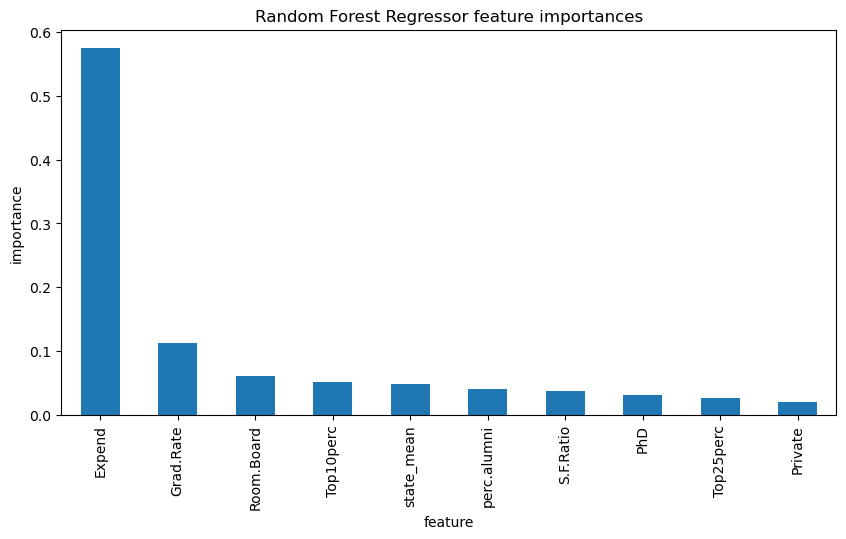

In [ ]:
# See what features the Random Forest model deems most important
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('feature')
plt.ylabel('importance')
plt.title('Random Forest Regressor feature importances');

## Final Model Selection

In [ ]:
# Compare scores of both models
models = {"Logistic Regression": lr_grid_cv.best_estimator_, "Random Forest": rf_grid_cv.best_estimator_}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Model:", name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("\n")

5472.434943141359

The random forest model has a lower cross-validation mean absolute error. It also exhibits less variability.

## Data Quantity Evaluation

In [29]:
# Different fractions of splits tested
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_pipe, X_train, y_train, train_sizes=fractions)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

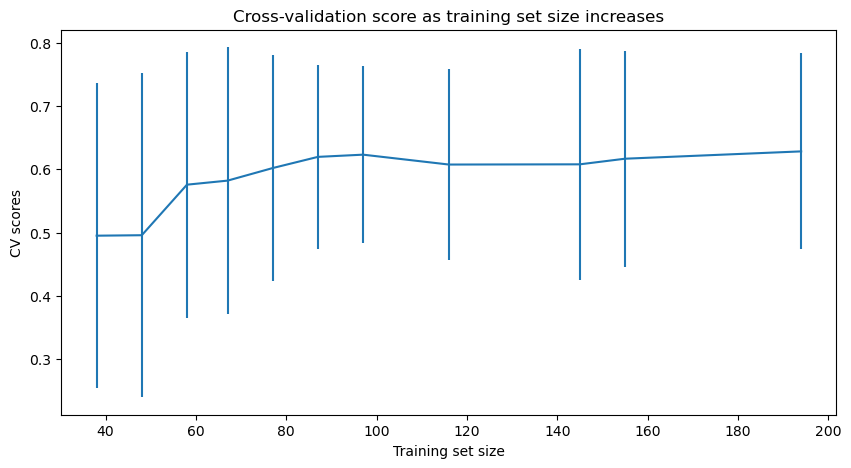

In [30]:
# scores at different train/test splits
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## Saving Best Model

In [ ]:
# Saving the best model to variable "best_model"
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
save_file(best_model, 'credit_model.pkl', '../models')

Writing file.  "../models/tuition_model.pkl"


## Suggestions

Purdue can already justify tuition increases without major institutional changes. However, enhancing key factors that influence tuition could further strengthen this justification and potentially justify even higher tuition. The best model indicates that instructional expenditure and graduation rate are the primary drivers of tuition, warranting further investigation. Currently, Purdue lies close to the center of both of these features' distributions suggesting room for improvement.

The following hypotheticals will be modelled:
1. Increasing instructional expedenture per student
2. Increasing graduation rate

In [41]:
purdue[['Expend', 'Grad.Rate']]

,Expend,Grad.Rate
198,8604,67


In [42]:
def predict_increase(features, deltas):
    purdue2 = X_purdue.copy()
    for f, d in zip(features, deltas):
        purdue2[f] += d
    return best_model.predict(purdue2).item() - best_model.predict(X_purdue).item()

## Suggestion #1: 

Test an increase in expedenture of -1000 to 8000.

In [43]:
inc = [i for i in range(-1000, 8001, 500)]
price_deltas = [predict_increase(['Expend'], [i]) for i in inc]

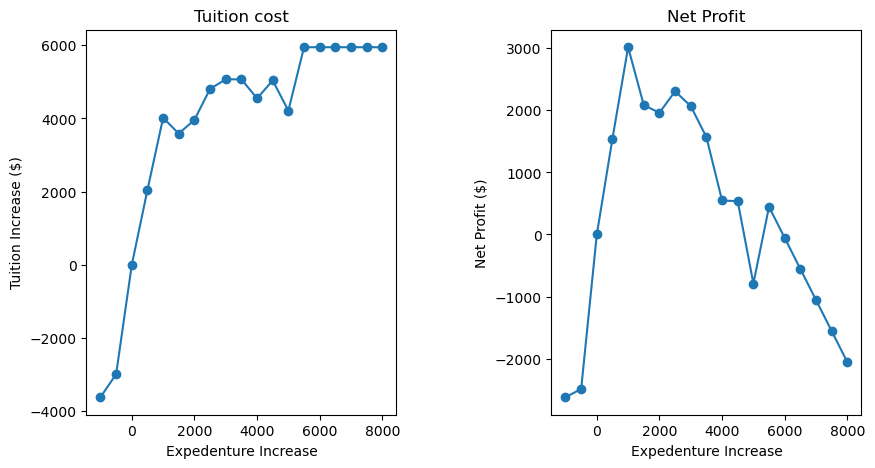

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(inc, price_deltas, 'o-')
ax[0].set(xlabel='Expedenture Increase', ylabel='Tuition Increase ($)', title='Tuition cost')
net_profit = [price_deltas[i] - inc[i] for i in range(len(inc))]
ax[1].plot(inc, net_profit, 'o-')
ax[1].set(xlabel='Expedenture Increase', ylabel='Net Profit ($)', title='Net Profit');

The model shows that an expedenture increase above $5,500 makes no difference to the tuition price and that an expedenture increase of $1,000 clearly nets the most "profit" or gain in tuition of $3,000.

## Suggestion #2: 

Test an increase in graduation rate of -3 to 33.

In [45]:
inc = [i for i in range(-3, 34, 3)]
price_deltas = [predict_increase(['Grad.Rate'], [i]) for i in inc]

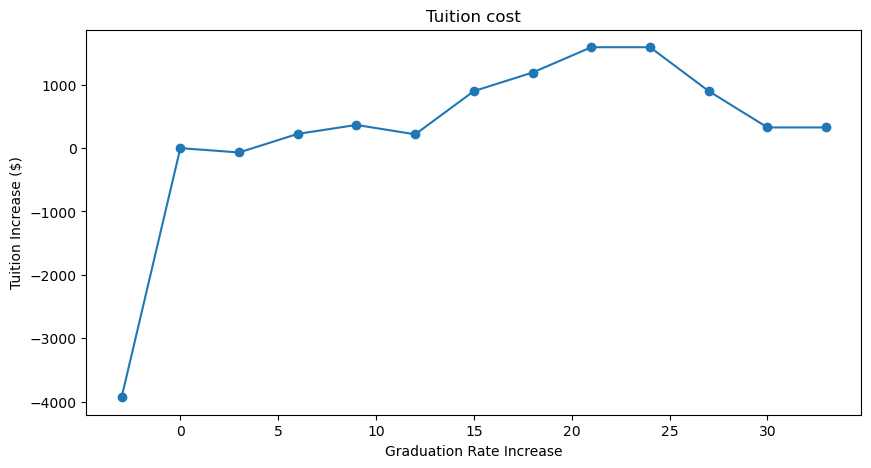

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(inc, price_deltas, 'o-')
ax.set(xlabel='Graduation Rate Increase', ylabel='Tuition Increase ($)', title='Tuition cost');

The model shows that a graduation rate increase would have fairly small effect on the tuition price, but an increase of 20% in the graduation rate could justify an increase in tuition of $1,600.

## Caveats

Caveats